# VowPal WABBIT

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Стахостический градиентный спуск
## 1.1 SGD

In [2]:
path_to_all_data = 'datasets/spooky-vw-tutorial/'
data_demo = pd.read_csv(os.path.join(path_to_all_data, 'weights_heights.csv'))

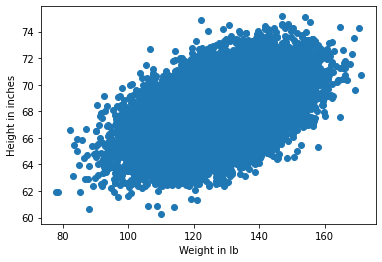

In [3]:
plt.scatter(data_demo['Weight'], data_demo['Height'])
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches');

# 1.2 Online learning

# 2.1 Label Encoding

In [4]:
df = pd.read_csv(os.path.join(path_to_all_data, 'bank_train.csv'))
labels = pd.read_csv(os.path.join(path_to_all_data, 'bank_train_target.csv'), header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


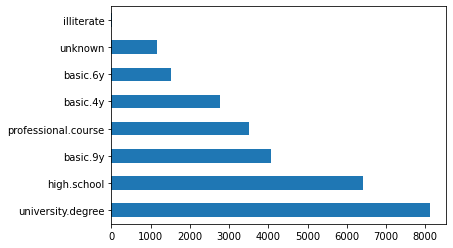

In [5]:
df['education'].value_counts().plot.barh();

In [6]:
label_encoder =LabelEncoder()

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


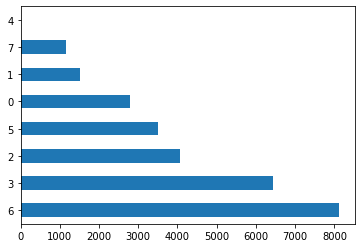

In [7]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [8]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [9]:
df.loc[1].job - df.loc[2].job

-1.0

In [10]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.values
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
    
    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))
print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6118
           1       0.00      0.00      0.00       781

    accuracy                           0.89      6899
   macro avg       0.44      0.50      0.47      6899
weighted avg       0.79      0.89      0.83      6899



# 2.2 One-Hot Encoding

In [11]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


In [12]:
onehot_encoder = OneHotEncoder(sparse=False)

In [13]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# VowPal Wabbit

(https://github.com/JohnLangford/vowpal_wabbit)

In [14]:
from vowpalwabbit import pyvw

In [15]:
!vw --help



VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all weights to an initial value of 
                                        arg.
  --random_weights arg                  mak

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


[20newsgroups dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)


## 3.1. News. Binary classification.

In [16]:
newsgroups = fetch_20newsgroups(path_to_all_data)

In [17]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [18]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('----')
print(target)
print('----')
print(text.strip())
print('----')

----
rec.autos
----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


In [19]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [20]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos'
              else -1 for target in newsgroups['target']]


In [21]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)

# with open(os.path.join(PATH_TO_ALL_DATA, '20news_train.vw'), 'w') as vw_train_data:
#     for text, target in zip(train_documents, train_labels):
#         vw_train_data.write(to_vw_format(text, target))
# with open(os.path.join(PATH_TO_ALL_DATA, '20news_test.vw'), 'w') as vw_test_data:
#     for text in test_documents:
#         vw_test_data.write(to_vw_format(text))

In [22]:
#!vw -d $/Users/muzalevskiy/Downloads/spooky-vw-tutorial/20news_train.vw \
#--loss_function hinge -f $PATH_TO_ALL_DATA/20news_model.vw

In [23]:
#!vw -i $PATH_TO_ALL_DATA/20news_model.vw -t -d $PATH_TO_ALL_DATA/20news_test.vw \
#-p $PATH_TO_ALL_DATA/20news_test_predictions.txt

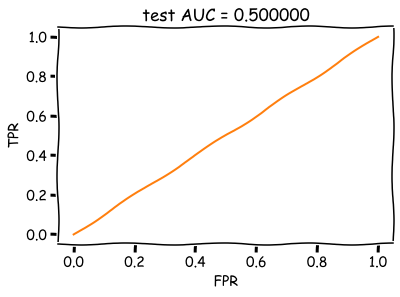

In [24]:
with open(os.path.join(path_to_all_data, '20news_test_predictions.txt')) as pred_file:
    test_prediction = [float(label)
                              for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0, 1], [0, 1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05, 1.05, -0.05,1.05]);

# 3.2. News. Multiclass classification

In [25]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

In [26]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)

In [27]:
with open(os.path.join(path_to_all_data, '20news_test_predictions_mult.txt')) as pred_file:
    test_prediction_mult = [float(label) for label in pred_file.readlines()]

In [28]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

In [29]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0, i])

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


# 3.3 IMDB

In [30]:
import pickle

In [31]:
# path_to_movies = os.path.expanduser('/Users/Documents/imdb_reviews')
# reviews_train = load_files(os.path.join(path_to_movies, 'train'))
with open(os.path.join(path_to_all_data, 'reviews_train.pkl'), 'rb') as reviews_train_pkl:
    reviews_train = pickle.load(reviews_train_pkl)
text_train, y_train = reviews_train.data, reviews_train.target

In [32]:
print('Number of documents in training data: %d' % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [33]:
# review_test = load_files(os.path.join(path_to_movies, 'test'))
with open(os.path.join(path_to_all_data, 'reviews_test.pkl'), 'rb') as reviews_test_pkl:
    reviews_test = pickle.load(reviews_test_pkl)
text_test, y_test = reviews_test.data, reviews_test.target
print(f'Number of documents in test data: {len(text_test)}')
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


In [34]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [35]:
y_train[0] # Хорошее ревью

1

In [36]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [37]:
y_train[1] # плохое ревью

0

In [38]:
to_vw_format(str(text_train[1]), 1 if y_train[1] == 1 else -1)

'-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

In [39]:
train_share = int(.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [40]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [41]:
# with open('movie_reviews_train.vw', 'w') as vw_train_data:
#     for text, target in zip(train, train_labels):
#         vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
# with open('movie_reviews_valid.vw', 'w') as vw_train_data:
#     for text, target in zip(valid, valid_labels):
#         vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
# with open('movie_reviews_test.vw', 'w') as vw_test_data:
#     for text in text_test:
#         vw_test_data.write(to_vw_format(str(text)))

In [42]:
!head -2 $path_to_all_data/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [43]:
!head -2 $path_to_all_data/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [44]:
!head -2 $path_to_all_data/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

In [45]:
#!vw -i $path_to_all_data/movie_reviews_train.vw --loss_function hinge -f $path_to_all_data/movie_reviews_model.vw

Error: bad model format!

finished run
number of examples = 0
weighted example sum = 0.000000
weighted label sum = 0.000000
average loss = n.a.
total feature number = 0
vw (d:\a\1\s\vowpalwabbit\io_buf.h:237): bad model format!


In [51]:
with open(os.path.join(path_to_all_data, 'movie_valid_pred.txt')) as pred_file:
    valid_prediction = [float(label)
                            for label in pred_file.readlines()]
print(f'Accuracy {round(accuracy_score(valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)}')
print('AUC: {}'.format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy 0.885
AUC: 0.942


In [52]:
# !vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
# -p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [54]:
with open(os.path.join(path_to_all_data, 'movie_test_pred.txt')) as pred_file:
    test_prediction = [float(label)
                          for label in pred_file.readlines()]
print(f'Accuracy: {round(accuracy_score(y_test, [int(pred_prob > 0) for pred_prob in test_prediction]), 3)}')
print(f'AUC: {round(roc_auc_score(y_test, test_prediction), 3)}')

Accuracy: 0.88
AUC: 0.94


In [55]:
# !vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw \
# --loss_function hinge --ngram 2 -f $PATH_TO_ALL_DATA/movie_reviews_model2.vw --quiet

In [56]:
# !vw -i$PATH_TO_ALL_DATA/ movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw \
# -p $PATH_TO_ALL_DATA/movie_valid_pred2.txt --quiet

In [57]:
with open(os.path.join(path_to_all_data, 'movie_valid_pred2.txt')) as pred_file:
    valid_prediction = [float(label)
                            for label in pred_file.readlines()]
print(f'Accuracy: {round(accuracy_score(valid_labels, [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)}')
print(f'AUC: {round(roc_auc_score(valid_labels, valid_prediction), 3)}')

Accuracy: 0.894
AUC: 0.954


In [58]:
# !vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
# -p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [60]:
with open(os.path.join(path_to_all_data, 'movie_test_pred2.txt')) as pred_file:
    test_prediction2 = [float(label)
                            for label in pred_file.readlines()]
print(f'Accuracy: {round(accuracy_score(y_test, [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)}')
print(f'AUC: {round(roc_auc_score(y_test, test_prediction2), 3)}')

Accuracy: 0.888
AUC: 0.952


# 3.4. StackOverflow

(https://www.ics.uci.edu/~duboisc/stackoverflow/)

![big-data-big-5ad56d.jpg](attachment:big-data-big-5ad56d.jpg)

In [61]:
!head -3 $path_to_all_data/stackoverflow_sample.vw

1 | i ve got some code in window scroll that checks if an element is visible then triggers another function however only the first section of code is firing both bits of code work in and of themselves if i swap their order whichever is on top fires correctly my code is as follows fn isonscreen function use strict var win window viewport top win scrolltop left win scrollleft bounds this offset viewport right viewport left + win width viewport bottom viewport top + win height bounds right bounds left + this outerwidth bounds bottom bounds top + this outerheight return viewport right lt bounds left viewport left gt bounds right viewport bottom lt bounds top viewport top gt bounds bottom window scroll function use strict var load_more_results ajax load_more_results isonscreen if load_more_results true loadmoreresults var load_more_staff ajax load_more_staff isonscreen if load_more_staff true loadmorestaff what am i doing wrong can you only fire one event from window scroll i assume not
4 |

In [62]:
!du -hs $path_to_all_data/stackoverflow_*.vw

1.2M	datasets/spooky-vw-tutorial//stackoverflow_sample.vw
